<a href="https://colab.research.google.com/github/s59mz/axu2cgb/blob/main/rf_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow import Tensor
print("Tensorflow version is ", tf.__version__)
print('Keras version      : ',keras.__version__)
import numpy as np
import os, sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import h5py as h5
from sklearn.metrics import classification_report, confusion_matrix
import random
import time
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation, GlobalAveragePooling1D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.layers import Reshape, Dense, Flatten, Add
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, History
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from random import shuffle
import glob
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle
from progressbar import ProgressBar
import matplotlib.pyplot as plt

Tensorflow version is  2.8.0
Keras version      :  2.8.0


## Download the 2018.01 Dataset from Deepsig
Deepsig has released multiple RF data sets, we are using the 2018 dataset.

This data set contains RF data with 24 different modulations at various SNR. Each of the 2555904 data inputs is 1024 samples long of complex (I Q) data.

You need to register  with Deepsig in order to download the dataset, go to https://www.deepsig.io/datasets, select the link for Dataset Download: 2018.01.OSC.0001_1024x2M.h5.tar.gz, register, dowlnload the file, and copy to the same directory containing this Jupyter notebook 

Note that the modulatiom class order in classes.tx is incorrect, and you should use the modulation class order as in this notebook.


In [ ]:
 !pwd
 !ls
 #!tar -xvzf 2018.01.OSC.0001_1024x2M.h5.tar.gz
 #!ls
 #!rm 2018.01.OSC.0001_1024x2M.h5.tar.gz 

/content
drive  sample_data


## 2018 Dataset 

### Read in RF Data
3 Arrays will be created. <br>
myData holds the 1024 I and Q time values for each input sample. <br>
myMods holds the one hot encoded RF class for each sample.<br>
mySNRs holds the SNR value for each sample.<br>



In [ ]:
#Note this is needed to aviod a tensorFlow memory issue
os.environ['TF_FORCE_CPU_ALLOW_GROWTH'] = 'true'

In [ ]:
#data_file = '2018.01/GOLD_XYZ_OSC.0001_1024.hdf5' # original dataset - 4096 samples per 26 SNR per 24 modulations
data_file = '/content/drive/MyDrive/datasets/RF/reduced_rf_dataset_XYZ.hdf5'  # reduced dataset - only 512 samples per snr, only upper 12 SNRs
file_handle = h5.File(data_file,'r+')

myData = file_handle['X'][:]  #1024x2 samples 106496 per mod
myMods = file_handle['Y'][:]  #mods 24
mySNRs = file_handle['Z'][:]  #snrs 26 x 4096 per snr

print(np.shape(myData))
print(np.shape(myMods))
print(np.shape(mySNRs))
file_handle.close()

np.random.seed(0)

(159744, 1024, 2)
(159744, 24)
(159744, 1)


### List the SNRs


In [ ]:
snrs = list(np.unique(mySNRs.T[0]))  
print(snrs)

[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


### Define the Modulaton classes

In [ ]:
mods = [
    'OOK',      '4ASK',      '8ASK',      'BPSK',   'QPSK',    '8PSK',
    '16PSK',    '32PSK',     '16APSK',    '32APSK', '64APSK',  '128APSK',
    '16QAM',    '32QAM',     '64QAM',     '128QAM', '256QAM',  
    'AM-SSB-WC','AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK','OQPSK']

num_classes = np.shape(mods)[0]
print("The number of classes is ", num_classes)


The number of classes is  24


### Examine RF input samples
The samples in data set are ordered by class, let's print out one example from each class.

In [ ]:
size, step

(159744, 6656)

In [ ]:
myData[0]

array([[ 1.0020003 , -1.8333519 ],
       [ 0.75831705, -2.4232779 ],
       [ 0.3741569 , -1.9650447 ],
       ...,
       [ 0.17182091, -0.4627035 ],
       [ 0.05880846,  0.07623821],
       [-0.26319447,  0.02489517]], dtype=float32)

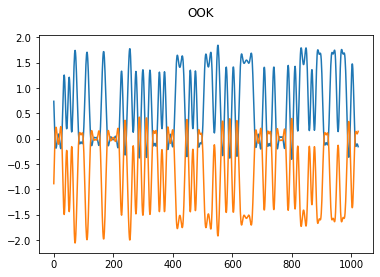

In [ ]:
x = 6655
plt.figure()
plt.suptitle( mods[np.argmax(myMods[x])])
plt.plot(myData[x,:,0])
plt.plot(myData[x,:,1])

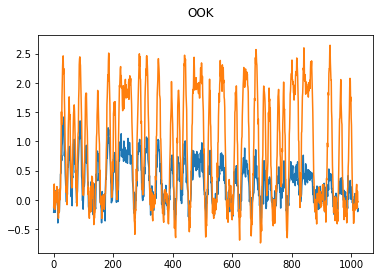

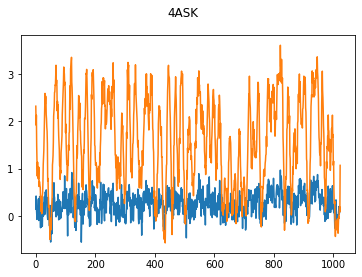

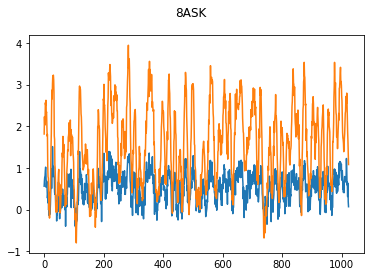

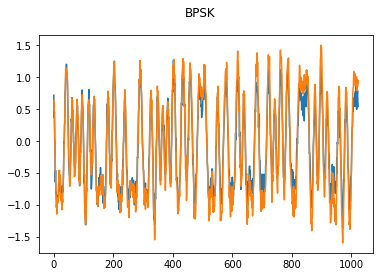

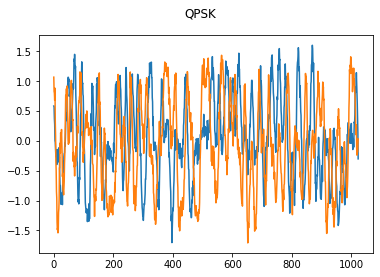

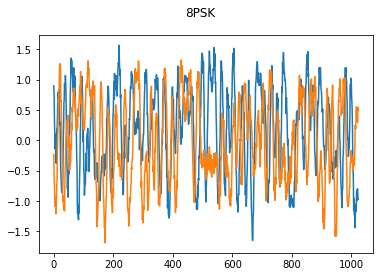

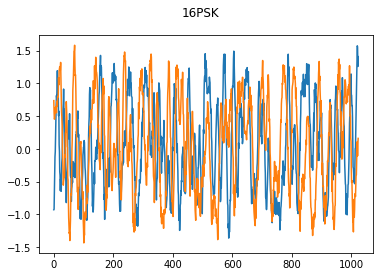

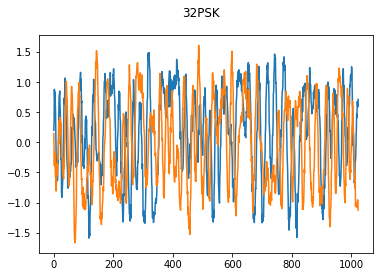

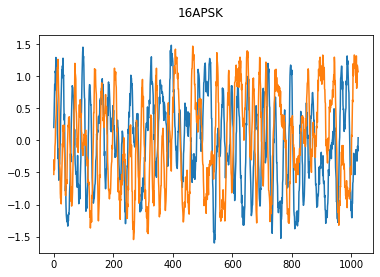

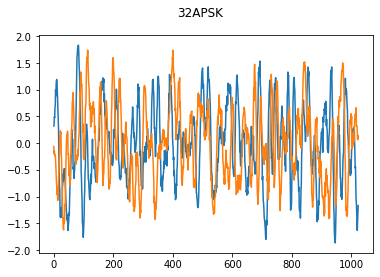

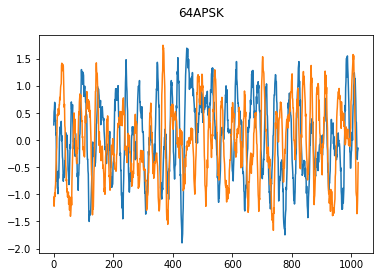

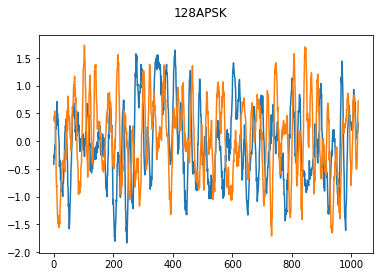

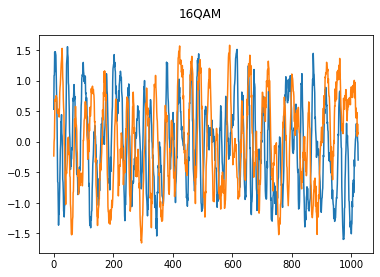

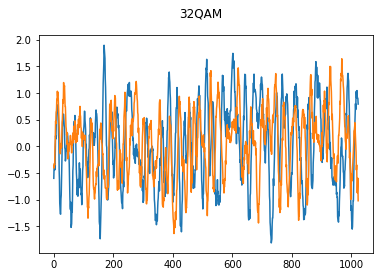

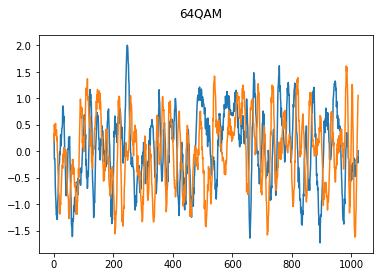

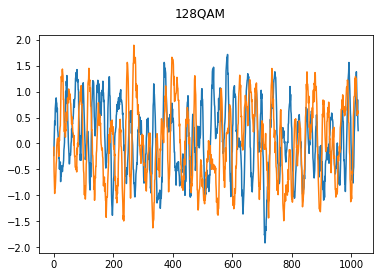

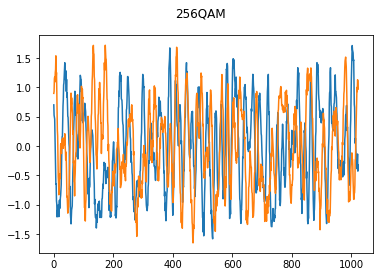

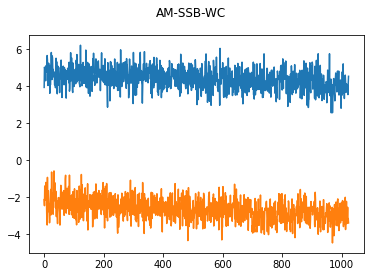

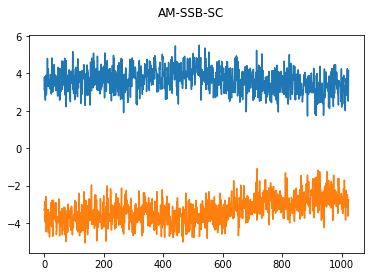

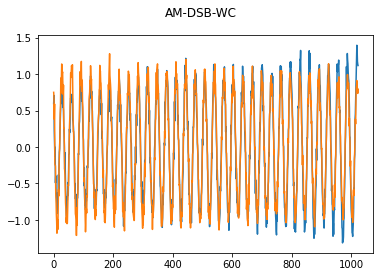

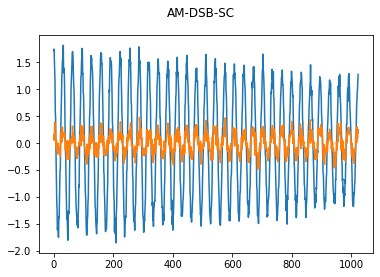

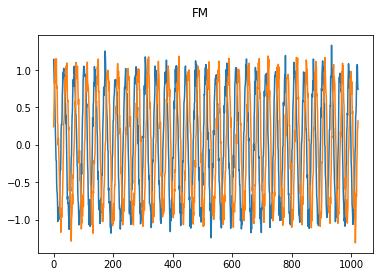

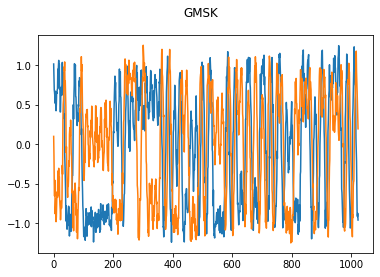

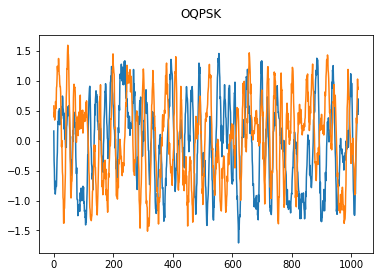

In [ ]:
#turn off warning about more than 10 figures plotted
plt.rcParams.update({'figure.max_open_warning': 0})

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

size = np.size(myData, axis = 0)
step = size//24

for x in my_range(1000, (size-1), step):
  plt.figure()
  plt.suptitle( mods[np.argmax(myMods[x])])
  plt.plot(myData[x,:,0])
  plt.plot(myData[x,:,1])

### Examine Input Data Range
The input datat is close to being centered around 0, and since the standard deviation is around 1.57, most of the data lies between -6 an +6 with some outliers. 

In [ ]:
print ("Max value of the data set = ", np.max(myData))
print ("Min value of the data set = ", np.min(myData))
print ("Mean value of the data set = ", np.mean(myData))
print ("Standard Deviation of the data set ", np.std(myData) )

Max value of the data set =  44.475887
Min value of the data set =  -37.12159
Mean value of the data set =  -0.004844276
Standard Deviation of the data set  2.090793


Lets examine where the outlyers are comming from. We will see below that all data is between -5 an 5 expect for AM-SSB-WC and the AM-SSB-SC modulations

In [ ]:
len = (myData.shape[0])
limit = 5
Max = np.zeros(len)
Min = np.zeros(len)
for i in range(0,len):
  Max[i] = (np.max(myData[i,:,0]))
  Min[i] = (np.min(myData[i,:,0]))
  if(Max[i] > limit or Min[i] < -limit):
   print ("index =", i, mods[np.argmax(myMods[i])])
plt.figure()
plt.plot(Max)
plt.plot(Min)

### Remove AM-SSB-WC and AM-SSB_SC from the data set
If we leave the AM-SSB-WC and AM-SSB-SC modulations in the data set we will see lower accuracy after quantizing the model to INT8. This is becuase we can more accurately quantize the floating point input data if it is over a smaller range with fewer outlyers as in seen in the other modulations 

In the next step we will remove these two modulations from the data set. If you want to leave these modulations in, you can skip the next step. Leaving these in will cause an additonal 5% accuracy drop after quantizing.

In [ ]:
#Skip this entire panel if you want to leave AM-SSB-WC and AM-SSB-SC modulations in the data set
#myData = np.concatenate((myData[0:1810432], myData[2023424:2555904]),axis=0)
#mySNRs = np.concatenate((mySNRs[0:1810432], mySNRs[2023424:2555904]),axis=0)
#myMods = np.concatenate((myMods[0:1810432], myMods[2023424:2555904]),axis=0)

myData = np.concatenate((myData[0:113152], myData[126464:159744]),axis=0)
mySNRs = np.concatenate((mySNRs[0:113152], mySNRs[126464:159744]),axis=0)
myMods = np.concatenate((myMods[0:113152], myMods[126464:159744]),axis=0)


#re-onehot encode myMods to 22 from 24
length = (np.size(myMods, axis=0))
temp = np.concatenate((myMods[:,0:17],myMods[:,19:24]), axis=1)
myMods = temp

mods = [
    'OOK',      '4ASK',      '8ASK',      'BPSK',   'QPSK',    '8PSK',
    '16PSK',    '32PSK',     '16APSK',    '32APSK', '64APSK',  '128APSK',
    '16QAM',    '32QAM',     '64QAM',     '128QAM', '256QAM',  
    'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK','OQPSK']

num_classes = np.shape(mods)[0]
print("The number of classes is ", num_classes)


print(np.shape(myData))
print(np.shape(mySNRs))
print(np.shape(myMods))

print ("Max value of the data set = ", np.max(myData))
print ("Min value of the data set = ", np.min(myData))
print ("Mean value of the data set = ", np.mean(myData))
print ("Standard Deviation of the data set ", np.std(myData) )


The number of classes is  22
(146432, 1024, 2)
(146432, 1)
(146432, 22)
Max value of the data set =  4.5126915
Min value of the data set =  -4.457516
Mean value of the data set =  0.0006922224
Standard Deviation of the data set  0.7962071


### Now lets look at how the SNRs are distributed across the data set
As you can see each SNR appears an equal number of times across the data set


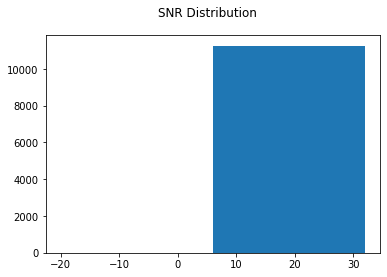

In [ ]:
plt.figure()
plt.suptitle("SNR Distribution")
plt.hist(mySNRs, bins = [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]) 
plt.show()

### Reshape RF data to 2D Matrix
We will reshape both the I and Q data from a 1024 long vector to 2D 1024x1 matrix to be conpatabile with 2D convolution commands supported by the DPU

In [ ]:
myData = myData.reshape(myData.shape[0], 1024, 1, 2) 

In [ ]:
myData.shape[3]

2

In [ ]:
myData[0]

array([[[ 1.0020003 , -1.8333519 ]],

       [[ 0.75831705, -2.4232779 ]],

       [[ 0.3741569 , -1.9650447 ]],

       ...,

       [[ 0.17182091, -0.4627035 ]],

       [[ 0.05880846,  0.07623821]],

       [[-0.26319447,  0.02489517]]], dtype=float32)

### Slpit Data into Trainnig and Validation set
We will use 80% of the data for the Training set and 20% for the Test set. 
The random_state input to the the train_test_split function is set to 0, which means the 80/20 split will be done in a repeatable manner. 

In [ ]:
X_train ,X_test ,Y_train ,Y_test, Z_train, Z_test =train_test_split(myData, myMods, mySNRs, test_size=0.2, random_state=0)
print (np.shape(X_test))
print (np.shape(Y_test))
print (np.shape(Z_test))
print (np.shape(X_train))
print (np.shape(Y_train))
print (np.shape(Z_train))
del myData, myMods, mySNRs

(29287, 1024, 1, 2)
(29287, 22)
(29287, 1)
(117145, 1024, 1, 2)
(117145, 22)
(117145, 1)


## Build a Simple Resnet  Model 


This resnet model was inspired by the model disussed in the following paper <br>
Over-the-Air Deep Learning Based Radio Signal Classification, <br>
IEEE JOURNAL OF SELECTED TOPICS IN SIGNAL PROCESSING, VOL. 12, NO. 1, <br>
FEBRUARY 2018 

In [ ]:
input_shp = list(X_train.shape[1:])
print("Dataset Shape={0} CNN Model Input layer={1}".format(X_train.shape, input_shp))
classes = mods

Dataset Shape=(117145, 1024, 1, 2) CNN Model Input layer=[1024, 1, 2]


Here we construct a resnet block which will be used multiple times in our model. In order to be compatabile with the Vitis-AI compilation tools we need to use a square kernel size (2x2) for the MaxPooling layer. Since the data is rectangular 1024x1, 512x1, ... we have enabled padding so the a square kernel size can be used.

In [ ]:
def resnet_block(input_data, filters, conv_size):
  x = Conv2D(filters, 1, activation=None, padding='same')(input_data)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters, conv_size, activation=None, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters, conv_size, activation=None, padding='same')(x)
  x = BatchNormalization()(x)
  x = Add()([x, input_data])
  x = Activation('relu')(x)
    
  y = Conv2D(filters, conv_size, activation=None, padding='same')(x)
  y = BatchNormalization()(y)
  y = Activation('relu')(y)
  y = Conv2D(filters, conv_size, activation=None, padding='same')(y)
  y = BatchNormalization()(y)    
  y = Add()([y, x])
  y = Activation('relu')(y)
  
  z = MaxPooling2D(2, strides = (2,1), padding = 'same') (y)
  return z



Here we construct a model with 4 resnet_blocks.
Note the 8x8 reshape layer before the GlobalAveragePooling2D layer. This is needed to reshape the 32x1 data shape to 8x8 to be compatabile with the Vitis-AI compilation tools, as the Xilinx DPU only supports square data shapes for this layer. 

In [ ]:
#Using 6 blocks will give small accuracy improvment with 5% decrease in performance
#num_resnet_blocks = 6

num_resnet_blocks = 4
num_filters = 32
kernel_size = 5,1

rf_input = Input(shape=input_shp, name = 'rf_input')

x = Conv2D(num_filters, (kernel_size), activation=None, padding='same')(rf_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

for i in range(num_resnet_blocks):
    x = resnet_block(x, num_filters, (kernel_size))

x = Conv2D(num_filters, (kernel_size), activation=None, padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# use if number of resnet blocks = 6
#x = Reshape((4,4,num_filters), input_shape = (16,1,num_filters)) (x)

# use if number of resent blocks = 4
x = Reshape((8,8,num_filters), input_shape = (32,1,num_filters)) (x)

x = GlobalAveragePooling2D()(x)
dense_1 = Dense(256, activation='relu')(x)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(128, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)
dense_3 = Dense(num_classes)(dropout_2)          
softmax = Activation('softmax', name = 'softmax')(dense_3)

optimizer= Adam(learning_rate=0.00050)
model = keras.Model(rf_input, softmax)
model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rf_input (InputLayer)          [(None, 1024, 1, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1, 32)  352         ['rf_input[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 1, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

Lets verify that our model is working. Because the weight are unitialize, all the probabilites will be close to a random guess of 0.045 (1/22)

In [ ]:
predict = model.predict(X_test[0:1])
print(predict)

[[0.04578632 0.04086398 0.04493326 0.03581764 0.03511302 0.0580802
  0.05176583 0.04023242 0.04516253 0.05232808 0.04930422 0.04637085
  0.05052567 0.05009727 0.04193851 0.0331387  0.05054359 0.05413763
  0.04327553 0.03828091 0.04051157 0.05179227]]


## TRAIN

### Set up batch and epoch size.

In [ ]:
nb_epoch = 50     # number of epochs to train on
batch_size = 1024  # training batch size

### Early stoping callback 
Will end training after 5 epochs with no accuracy improvement on test data set

In [ ]:
### Callback
checkpoint_dir = 'resnet_checkpoints'
#os.mkdir(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath =checkpoint_dir + '/best_checkpoint.h5', 
                                                 verbose = 1,
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode='auto')
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        mode='auto',
        verbose = 1)

### Start Training

In [ ]:
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks = [ cp_callback,earlystopping_callback]
    )


Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 1.6486 - accuracy: 0.3979
Epoch 00001: val_loss improved from inf to 8.19903, saving model to resnet_checkpoints/best_checkpoint.h5
115/115 [==============================] - 46s 351ms/step - loss: 1.6486 - accuracy: 0.3979 - val_loss: 8.1990 - val_accuracy: 0.0315
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


115/115 [==============================] - ETA: 0s - loss: 1.0278 - accuracy: 0.5672
Epoch 00002: val_loss did not improve from 8.19903
115/115 [==============================] - 37s 322ms/step - loss: 1.0278 - accuracy: 0.5672 - val_loss: 13.3375 - val_accuracy: 0.0683
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 0.8559 - accuracy: 0.6303
Epoch 00003: val_loss did not improve from 8.19903
115/115 [==============================] - 37s 323ms/step - loss: 0.8559 - accuracy: 0.6303 - val_loss: 16.3241 - val_accuracy: 0.1861
Epoch 4/50
115/115 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.6681
Epoch 00004: val_loss improved from 8.19903 to 1.62469, saving model to resnet_checkpoints/best_checkpoint.h5
115/115 [==============================] - 38s 327ms/step - loss: 0.7494 - accuracy: 0.6681 - val_loss: 1.6247 - val_accuracy: 0.5601
Epoch 5/50
115/115 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.7003
Epoch 00005

In [ ]:
model.save('/content/drive/MyDrive/datasets/RF/rf-model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Training Completed
Reload the best weights once training is fininsed. 

In [ ]:
best_checkpoint = checkpoint_dir + '/best_checkpoint.h5'
model.load_weights(best_checkpoint)
#!mkdir -p fp_model
model.save ('/content/drive/MyDrive/datasets/RF/resnet_fp_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Evaluate Model Performance

In [ ]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test,  verbose=0, batch_size=batch_size)
print(score)

[0.9736599326133728, 0.6148803234100342]


The Top1 accuracy should be 62%


### Confusion Matrix


In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize = (15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    label_len = np.shape(labels)[0]
    tick_marks = np.arange(label_len)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([num_classes,num_classes])
confnorm = np.zeros([num_classes,num_classes])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,num_classes):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

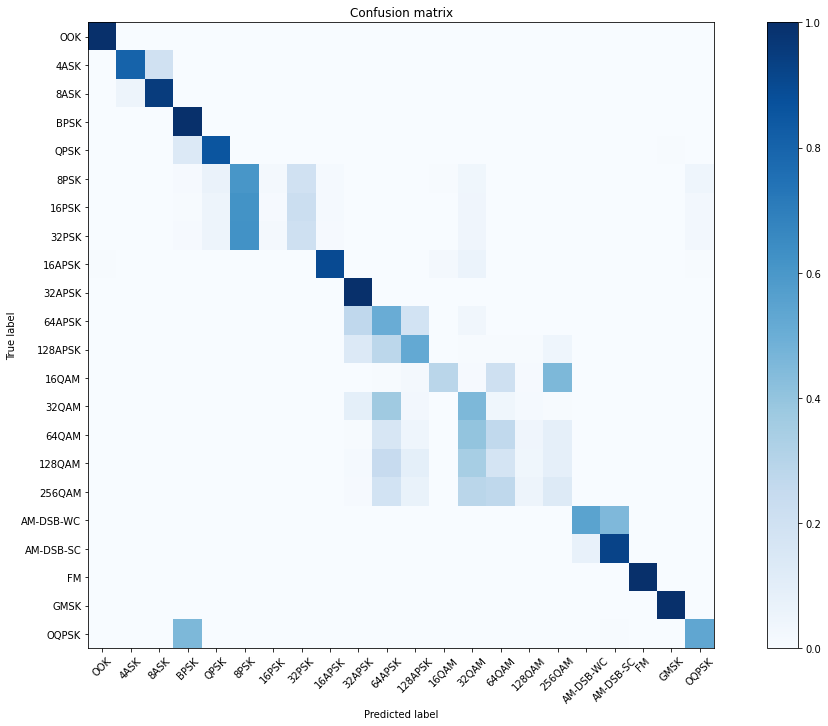

In [ ]:
plot_confusion_matrix(confnorm, labels=classes)

### Generate Classification Report

In [ ]:
Y_pred = model.predict(X_test,batch_size=batch_size)
y_pred = np.argmax(Y_pred, axis = 1)
y_actual = np.argmax(Y_test, axis = 1)
classificationreport_fp = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_fp)

              precision    recall  f1-score   support

         OOK       0.99      1.00      1.00      1331
        4ASK       0.94      0.80      0.87      1340
        8ASK       0.83      0.95      0.88      1330
        BPSK       0.61      1.00      0.76      1328
        QPSK       0.84      0.86      0.85      1344
        8PSK       0.33      0.60      0.42      1297
       16PSK       0.21      0.01      0.02      1299
       32PSK       0.33      0.21      0.26      1293
      16APSK       0.96      0.90      0.93      1297
      32APSK       0.65      1.00      0.78      1289
      64APSK       0.29      0.51      0.37      1337
     128APSK       0.54      0.52      0.53      1321
       16QAM       0.91      0.29      0.44      1401
       32QAM       0.26      0.46      0.33      1312
       64QAM       0.26      0.26      0.26      1301
      128QAM       0.24      0.04      0.07      1365
      256QAM       0.15      0.13      0.14      1359
   AM-DSB-WC       0.88    

Precision Measures the  Accuracy of the positive predictions.
Precision = TP/(TP + FP)

Recall Measures the fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

The F1 score is measure of a weighted harmonic mean of precision and recall. 

Support is the number of values for each class.

Looking at the f1- scores for the different classes, we can see that the model is more accuracte with some classses than others.
For example, the model is not able to correctly inentify the hiher order PSK and QAM modulations as other classes.   

### Accuracy vs. SNR
Now lets see how the model accuracy is effcted by SNR.

In [ ]:
batchsize = 1024
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = model.predict(x_batch)
        
        #Pediction values are onehote, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  7% (1 of 13) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:11

SNR:  6 accuracy 0.4765625


 15% (2 of 13) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:07

SNR:  8 accuracy 0.57421875


 23% (3 of 13) |#####                    | Elapsed Time: 0:00:01 ETA:   0:00:06

SNR:  10 accuracy 0.60302734375


 30% (4 of 13) |#######                  | Elapsed Time: 0:00:02 ETA:   0:00:04

SNR:  12 accuracy 0.634765625


 38% (5 of 13) |#########                | Elapsed Time: 0:00:02 ETA:   0:00:04

SNR:  14 accuracy 0.61181640625


 46% (6 of 13) |###########              | Elapsed Time: 0:00:02 ETA:   0:00:02

SNR:  16 accuracy 0.64111328125


 53% (7 of 13) |#############            | Elapsed Time: 0:00:03 ETA:   0:00:02

SNR:  18 accuracy 0.6318359375


 61% (8 of 13) |###############          | Elapsed Time: 0:00:03 ETA:   0:00:02

SNR:  20 accuracy 0.6416015625


 69% (9 of 13) |#################        | Elapsed Time: 0:00:04 ETA:   0:00:01

SNR:  22 accuracy 0.642578125


 76% (10 of 13) |##################      | Elapsed Time: 0:00:04 ETA:   0:00:01

SNR:  24 accuracy 0.626953125


 84% (11 of 13) |####################    | Elapsed Time: 0:00:05 ETA:   0:00:01

SNR:  26 accuracy 0.63525390625


 92% (12 of 13) |######################  | Elapsed Time: 0:00:06 ETA:   0:00:00

SNR:  28 accuracy 0.623046875


100% (13 of 13) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


SNR:  30 accuracy 0.64013671875


<Figure size 72x72 with 0 Axes>

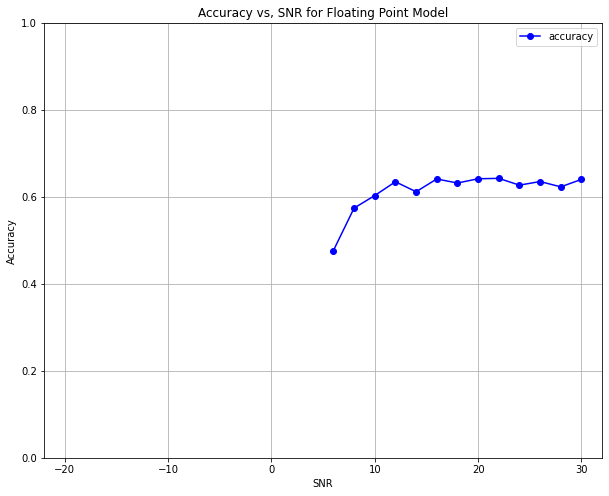

In [ ]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for Floating Point Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

Are you can see accurccy SNRs below -10db the Top1 accuracy is no better than a random guess (1/24), and once SNR is above 10db the Top1 accuracy is over 98%.

## Vitis AI
The Vitis-AI tools will be used the Quantize and Compile the model for accleration on the DPU. <br>
Vitis-AI 1.3 now natively supports keras in TensorFlow2, and we can directly read in the .h5 model. 

## Quantize Model to INT8
The Vitis-AI Quantizer uses a  small set of unlabeled samples to analyze the distribution of the activations. We will use 1000 input samples from the test set. <br>

The quantized.h5 model that is produced will be used as input to the Vitis-AI Quantizer

In [ ]:
# reload the model in case it was closed
!ls -l fp_model/
model = tf.keras.models.load_model('fp_model/resnet_fp_model.h5')
 
from tensorflow_model_optimization.quantization.keras import vitis_quantize
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = X_test[1:1000])

# Save the model
!mkdir -p quantize_results
quantized_model.save('quantize_results/quantized_model.h5')
!ls -l quantize_results

### Load and Compile Model for Evaluation
We can now load and recompile the INT8 model and run evaluations to compare with the floating point model

### Evalute  Model INT8 Performance

In [ ]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('quantize_results/quantized_model.h5')

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = q_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print(score)

The Overall Top-1 score has gone down by about 3% due to quantization

### Classification Report for INT8 Model

In [ ]:
batch_size = 128
Y_pred = q_model.predict(X_test,batch_size=batch_size)
y_pred = np.argmax(Y_pred, axis = 1)
y_actual = np.argmax(Y_test, axis = 1)
classificationreport_int8 = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_int8)

### Accuracy vs SNR for INT8 Model

In [ ]:
batchsize = 128
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = q_model.predict(x_batch)
        
        #Pediction values are 0-24, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

In [ ]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for INT8 Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

The Accuracy vs SNR looks very similar to the floating point model, expect the accuracy is down by about 5% for higher SNRs from the floating point model

## Optional Step Quantizer Fine Tuning
The Vitis-AI quantizer supports fine tuning, which can be used to recover some of the accuracy lost when quantizing. 
Fine tuning does use the entire training data set, and this step will take a long time to run. If you want to skip this step you can move on to compiling the model for the DPU.


Quantize finetuning is similar to float model finetuning. The difference is that quantize finetuning uses the APIs of the vai_q_tensorflow2 to rewrite the float graph to a quantized model before the training starts. 

When quantize fine tuning it is often beneifical to use a smaller learning rate. For the orginal floating point training we used a learning rate of 0.0005 For Fine tuning we will use a learning rate of 0.0001.

In [ ]:
# load the orginal floating point model
model = tf.keras.models.load_model('fp_model/resnet_fp_model.h5')
 
# *Call the vai_q_tensorflow2 api to create the quantize training model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
quantizer = vitis_quantize.VitisQuantizer(model)
model = quantizer.get_qat_model()

model.compile(
#use new learning rate
optimizer= Adam(learning_rate=0.0001),
loss= 'categorical_crossentropy',
metrics=["accuracy"])

print(model.summary())
    
history = model.fit(X_train,Y_train,
  epochs = 5,                
  callbacks = [
  keras.callbacks.ModelCheckpoint(
  filepath='quantize_results/fine_tuned_model.h5',
  save_best_only=True,
  #monitor='categorical_crossentropy',
  monitor= 'accuracy',
  mode = 'auto',
  verbose=1)])


    ### Evalute Model INT8 Performance after Quantize Aware Training "Fine Tuning"

In [ ]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  ft_model = tf.keras.models.load_model('quantize_results/fine_tuned_model.h5')

ft_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = ft_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print(score)

After fine tuning the accuarcy has improved, you should that the accuarcy has improved to around 60.5%.

### Accuracy vs SNR for INT8 Model after Fine Tuning

In [ ]:
batchsize = 128
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = ft_model.predict(x_batch)
        
        #Pediction values are 0-24, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

In [ ]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for Fine Tuned INT8 Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

## Compile Model for DPU
The Vitis-AI compiler reads in the quantized model and generates an xmodel file which the instruction set for the Xilinx Deep Learning Processor (DPU). The arhictecture option (-a) is used to specify a json file which indicates which hw target the DPU is being compiled for.

In [ ]:
# Select HW Target Choose Either Quantized or Fine Tuned Model
#For ZCU104
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json -o vai_c_output -n rfClassification
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/fine_tuned_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json -o vai_c_output -n rfClassification

#For ZCU102 
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU102/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/fine_tuned_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU102/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Alveo U50
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCAHX8H/U50/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/fine_tuned_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCAHX8H/U50/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Versal VCK190
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCVDX8G/VCK190/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"
!vai_c_tensorflow2 -m /workspace/files/quantize_results/fine_tuned_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCVDX8G/VCK190/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

## Generate Graph Visualization with xir tool.
You will see a compiler message about the number of  subgraphs:
Total device subgraph number 3, DPU subgraph number 1 <br>
This means that are 3 subgraphs created, 1 for the input layer, 1 for for everything up the softmax layer (which runs on the DPU), and one for the softmax. <br>

The softmax layer can  optionally be acclerated in programmable logic, however in this tutorial we will implement the softmax layer on the CPU.

You can use the the xir command generate a .png file to visulize the graph layers.

In [ ]:
!xir png /workspace/vai_c_output/rfClassification.xmodel xmodel.png

### Write out  samples  of Test Data to be used later for HW testing
The python function we will run in the target board will read in these numpy files containing the RF data, class, and SNR.

In [ ]:
np.save('/workspace/rf_input.npy', X_test[0:1000,:,:])
np.save('/workspace/rf_classes.npy', Y_test[0:1000])
np.save('/workspace/rf_snrs.npy', Z_test[0:1000])

Now that a dpu xmodel file has been created you are ready to run on target board. You will need to copy the above 3 files, and the xmodel file from the compiler to your target board.

You can close this notebook by entering CtrlC at the console, close the docker container by entering CtrlD, and the proceed with the Tutorial readme instructions.